In [31]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forecast as fc
import utm
import pickle

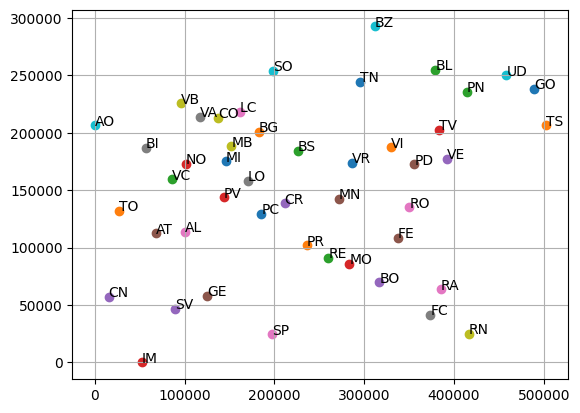

In [32]:
# loading data

provinces = pd.read_csv('..\data\dati-province\dpc-covid19-ita-province.csv')
today = '2021-06-26T17:00:00'
today_data = provinces.loc[provinces['data']==today]

population = pd.read_csv('..\data\Popolazione_province.csv', index_col=0)

p_list = pd.read_csv('..\data\Provinces_list.csv')['Sigla'].tolist()

lon = today_data.loc[today_data['sigla_provincia'].isin(p_list)]['long'].values
lat = today_data.loc[today_data['sigla_provincia'].isin(p_list)]['lat'].values

sigla = today_data.loc[today_data['sigla_provincia'].isin(p_list)]['sigla_provincia'].values
z = today_data.loc[today_data['sigla_provincia'].isin(p_list)]['totale_casi'].values

coords = np.array([utm.from_latlon(lat, lon, 32, 'T')[0:2] for lat,lon in zip(lat,lon)])
x0, y0 = min(coords[:,0]), min(coords[:,1])
coords = coords - np.array((x0, y0))

n_points = len(coords)

plt.figure()
for i, (x,y) in enumerate(coords):
    plt.scatter(x, y)
    plt.text(x, y, sigla[i])
plt.grid(True)



In [33]:
test_set = ['MO','RO', 'VI', 'AL', 'BI', 'PN', 'MB']
len(test_set)

7

In [34]:
# Distance matrix
D = np.zeros((n_points,n_points))
for i in range(n_points):
    for j in range(i+1,n_points):
        x1 = coords[i,0]
        x2 = coords[j,0]
        y1 = coords[i,1]
        y2 = coords[j,1]
        D[i,j]=((x1-x2)**2 + (y1-y2)**2)**0.5
        D[j,i]=D[i,j]

df_distances = pd.DataFrame(D,columns=sigla, index = sigla)




In [ ]:
# Extracting data for each province
df_list = []
for pr in p_list:
    df_list.append(provinces.loc[provinces['sigla_provincia']==pr])

n_days = df_list[0]['totale_casi'].values.shape[0]
new_pos_dict = {}

# index = p_list.index('BO')

plot_Flag=False
if plot_Flag:
    for index, sigla in enumerate(p_list):
        plt.figure()
        plt.title(sigla)
        my_data = df_list[index]
        pos_tot = my_data['totale_casi'].values/population['Residenti'][sigla]*100000
        new_pos = pos_tot.copy()
        new_pos[1:] = (pos_tot[1:]-pos_tot[:-1])
        new_pos_dict.update({sigla: new_pos})
        plt.plot(new_pos, label=sigla)
        plt.grid(True)

In [ ]:
# Fitting data with Forecast class

waves_dict = {}

for index, sigla in enumerate(p_list):
    print('Fitting for: '+sigla)
    new_pos_tot = new_pos_dict[sigla]

    t0=14
    T=new_pos_tot.shape[0]
    tt_forecast = np.arange(t0,T)
    rt_list = []

    my_prediction = np.zeros(T-t0)

    Forecast = fc.n_waves(new_pos_tot,window=7)
    fit_data = np.zeros(T)
    for t in tt_forecast:
        fit_data[t] = Forecast.daily_update()
        rt_list.append(Forecast.rt)
        my_prediction[t-t0] = Forecast.predict(t+1)

    waves_dict.update({sigla: Forecast.L_waves})



In [ ]:
# Save the dictionary to a file using pickle
import pickle

save_flag=False
if save_flag:
    with open('..\data\provinces_waves.pickle', 'wb') as file:
        pickle.dump(waves_dict, file)

In [30]:
coord_dict = dict(zip(sigla,coords))

save_flag=False
if save_flag:
    with open('..\data\coordinates_dict.pickle', 'wb') as file:
        pickle.dump(coord_dict, file)

    with open('..\data\distances_df.pickle', 'wb') as file:
        pickle.dump(df_distances, file)

In [29]:
coord_dict.keys()

dict_keys(['PC', 'PR', 'RE', 'MO', 'BO', 'FE', 'RA', 'FC', 'RN', 'UD', 'GO', 'TS', 'PN', 'IM', 'SV', 'GE', 'SP', 'VA', 'CO', 'SO', 'MI', 'BG', 'BS', 'PV', 'CR', 'MN', 'LC', 'LO', 'MB', 'BZ', 'TN', 'TO', 'VC', 'NO', 'CN', 'AT', 'AL', 'BI', 'VB', 'AO', 'VR', 'VI', 'BL', 'TV', 'VE', 'PD', 'RO'])